本章勘误：87面，' import matplotlib.pyplot as plt ' 后面一行，' some_digit = X\[0\] '无法取得第一行，原因是X是Df数据

因此我提前令 X = np.array(X)，这样就可以执行' some_digit = X\[0\] '

此外，标注暂不讨论的地方，或为暂不清楚

前排提示，有关cross_val_predict的地方可能会消耗相当时间

# 获取数据集

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()  # mnist 是一个键值对字典，其值是DataFrame数表

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

DESCR: 描述数据集；

data：一个数组，一个实例一行，一个特征一列；一张图片有28\*28个像素点，因此一个实例有784个像素数据

target：带标记的数组，即该实例是数字几

In [2]:
X, y = mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

In [3]:
import numpy as np
X = np.array(X)  # 将X从Df数据改为ndarray数据，后续方便处理
(y == '5').value_counts()  # 这是补充步骤，可以先留个印象，由此步可知5占大约10%

False    63687
True      6313
Name: class, dtype: int64

## 预览图片

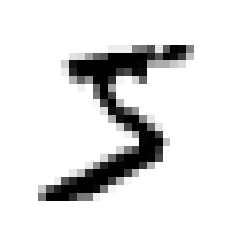

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
# %matplotlib notebook

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 正常显示中文

some_digit = X[0]  # 取数字特征，转化为ndarray数组
some_digit_image = some_digit.reshape(28, 28)  # 将一维数字特征重组为2维

plt.imshow(some_digit_image, cmap='binary')  # 颜色为二值，即仅黑白
plt.axis('off')  # 关掉轴
plt.show()

In [5]:
y[0]  # 查看对应标签是否为5

'5'

In [6]:
y = y.astype(np.uint8)  # 将全部标签转化为整数型

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]  # 划分训练集测试集及其标签

> 原数据集已经随机打乱，因此可以直接切割，一般情况下需要用 train_test_splt() 或 StratifiedShuffleSplit() 随机抽样

# 建立一个二元分类器（5和非5）

In [8]:
y_train_5 = (y_train == 5)  # 训练集中标签是5的数据标记为True（1），其他为False（0）
y_test_5 = (y_test == 5)  # 测试集中标签是5的数据标记为True（1），其他为False（0）

In [9]:
y_train_5

0         True
1        False
2        False
3        False
4        False
         ...  
59995    False
59996    False
59997     True
59998    False
59999    False
Name: class, Length: 60000, dtype: bool

## 梯度下降分类器

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)  
# 训练时是随机的，每次结果不一样，要改为可复现的，需要指定随机数种子
sgd_clf.fit(X_train, y_train_5)  
# 实际上也可以用来做多分类，sgd_clf.fit(X_train, y_train)即可，但是效果可能很差，在4.1.1中发现预测结果是3

SGDClassifier(random_state=42)

In [11]:
sgd_clf.predict([some_digit])

array([ True])

# 性能测量（混淆矩阵，查全查准率等）

可以自定义k折交叉验证函数（略）

## K折交叉验证

In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')  # 3折交叉验证
# scoring用'accuracy'，即精确匹配，在二分类用

array([0.95035, 0.96035, 0.9604 ])

> 精度高，但主要是因为只有10%的数字是5，因此即便预测全部非5，精度也有90%，下面进行验证

### 自定义一个傻瓜分类器（全部预测为非5）

In [13]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):  # 嵌套一个BaseEstimator，暂不讨论原因
    def fit(self, X, y=None):
        return self  # fit() 不做任何处理
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)  # predict() 返回全部为0（向量），即非5

> 可见，自定义分类器一般要包括fit()和predict()

In [14]:
# k折交叉验证
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

可见全部预测为非5，精度也有90%

## 混淆矩阵（用于描述性能情况）

In [15]:
from sklearn.model_selection import cross_val_predict  # K折交叉预测，用于构建混淆矩阵
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
# cross_val_predict 用于在训练集上进行预测，用于做训练集的混淆矩阵和F1分数等

In [16]:
y_train_pred  # 结果是标签

array([ True, False, False, ...,  True, False, False])

In [17]:
from sklearn.metrics import confusion_matrix  # 混淆矩阵
confusion_matrix(y_train_5, y_train_pred)  # 二分类的混淆矩阵就是2*2，n分类则n*n

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

|        | 预测真 Positive | 预测假 Negative |
| ------ | ------ | ------ |
| 真实真 True |  TP 53892 | TN 687 |
| 真实假 False|  FP 1891  |  FN 3530  |

> 该表仅用于解释标签

混淆矩阵表示仍然有错误的分类，一个完美的分类器只有主对角线有值，即全部正确分类，这里可以参考西瓜书
 
$查准率(精度)=\frac{TP}{TP + FP}$ ，纵向

$查全率(召回率)=\frac{TP}{TP + TN}$ ， 横向

完美模型的查全率和查准率都是1

## 精度和召回率

In [18]:
from sklearn.metrics import precision_score, recall_score  # sklearn中的查全率、查准率函数，也可以手动计算
print('查准率：',precision_score(y_train_5, y_train_pred))  # == 51933/(51933 + 2646)
print('查全率：',recall_score(y_train_5, y_train_pred))

查准率： 0.8370879772350012
查全率： 0.6511713705958311


有83.7%的概率是准确的，65.1%的5被找出来

### F1分数

$F_1$分数是查全率和查准率的谐波平均值，用于简单比较两个模型的精度

$ F_1=\frac{2}{\frac{1}{精度}+\frac{1}{召回率}}=\frac{TP}{TP+\frac{FN+FP}{2}} $

sklearn也提供了现成函数 f1_score，F1分数对于精度和召回率比较接近的模型比较有用

In [19]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

> 查准率和查全率是负相关关系，有时候仅仅需要极高的精度（如拦截垃圾信息），有时候则只需要极高的召回率（如安保设施），因此选择P、R或$F_1$要根据研究目的而定

## 精度和召回率的权衡（PR）

关于计算P/R的函数，参数是（真实标签，预测标签）

而有关曲线（_curve）的函数，参数是（真实标签，预测分数）

> 曲线相关函数目的是得出不同阈值情况下precisions和recalls或TPR和FPR的各个取值，从而绘制PR或ROC曲线

In [20]:
y_scores = sgd_clf.decision_function([some_digit])  # 可以返回一个决策分数

In [21]:
y_scores

array([2164.22030239])

In [22]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
# 该方法（method）返回决策分数

### PR图

In [23]:
from sklearn.metrics import precision_recall_curve  # PR曲线方法
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [24]:
import pandas as pd
pd.DataFrame(precision_recall_curve(y_train_5, y_scores))  # 预览一下结果，发现thresholds最后一个是NaN

,0,1,2,3,4,5,6,7,8,9,...,59957,59958,59959,59960,59961,59962,59963,59964,59965,59966
0,0.090401,0.090386,0.090388,0.090389,0.090391,0.090392,0.090394,0.090395,0.090397,0.090398,...,0.777778,0.875000,0.857143,0.833333,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
1,1.000000,0.999816,0.999816,0.999816,0.999816,0.999816,0.999816,0.999816,0.999816,0.999816,...,0.001291,0.001291,0.001107,0.000922,0.000922,0.000738,0.000553,0.000369,0.000184,0.0
2,-106527.453005,-105763.222401,-105406.296523,-104799.721326,-104613.214899,-104301.774274,-104269.965180,-104176.497972,-103830.566400,-103724.090229,...,34547.447029,34662.209500,35261.179277,35987.203075,36801.606970,37026.251165,38871.263919,42216.055628,49441.437659,NaN


In [25]:
# 定义函数，利用plt来作图
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='精度')
    plt.plot(thresholds, recalls[:-1], 'g-', label='召回率')
    plt.xlabel('阈值')
    plt.legend()
    plt.grid()
    plt.title('PR曲线')
    plt.show()

> 注：precisions[:-1]和recalls[:-1]都去掉最后一个数，是因为thresholds最后一个值是NaN，如果不切片就报错

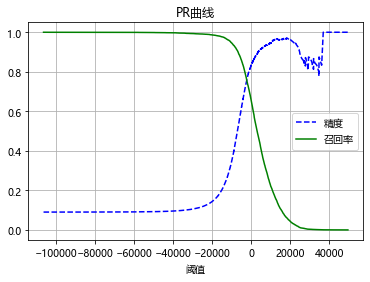

In [26]:
# 用自定义函数作图
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

### 获得任务需要的精度的阈值

In [27]:
# 得到目标精度(这里是90%)的阈值
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
# np.argmax(条件)，返回符合条件的最大索引
print(threshold_90_precision)  # 该索引就是精度

3370.0194991439557


### 用目标精度的阈值进行预测

In [28]:
y_train_pred_90 = (y_scores >= threshold_90_precision)  # y_scores包含全部预测的分数，因此与目标阈值比较即可

In [29]:
print(y_train_pred_90)

[False False False ...  True False False]


In [30]:
# 检查一下精度和召回率
print('精度：', precision_score(y_train_5, y_train_pred_90))
print('召回率：', recall_score(y_train_5, y_train_pred_90))

精度： 0.9000345901072293
召回率： 0.4799852425751706


## ROC曲线

### SGDClassifier的ROC曲线

TPR 真正率，FPR 假正率

$TPR=\frac{TP}{TP+TN}$

$FPR=\frac{TN}{TP+TN}=1-TPR$

可见ROC的参数更关注正类的情况，如果正类比较多或者关注真正类，建议用ROC

In [31]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [32]:
# 定义ROC函数做图
def plot_roc_curve(fpr, tpr, label=None):  # label 默认是无
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1],[0, 1], 'k--')  
    # 连接对角线，对角线表示纯随机分类的ROC曲线，模型ROC应越远离越好
    plt.xlabel('假正率FPR')
    plt.ylabel('真正率TPR')
    plt.title('ROC曲线')
    plt.grid()
    plt.show()

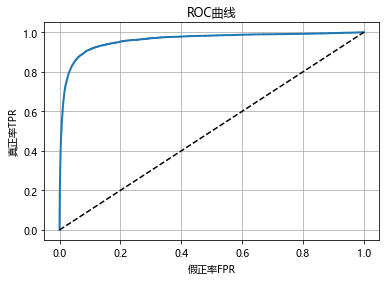

In [33]:
plot_roc_curve(fpr, tpr, 'SGD分类器')

ROC曲线下方的面积就是AUC分数，AUC越大效果越好

sklearn提供计算AUC的函数 roc_auc_score()

In [34]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

> 正类很少或关注假正类时，用PR曲线，否则是ROC曲线，这里看起来ROC曲线表现很好，但主要是因为5（正类）很少，因此应该用PR曲线评估

### 随机森林的ROC曲线

In [35]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')
# cross_val_predict做混淆矩阵用
# method='predict_proba' 返回正,负类概率作为分数，前面的SGD分类器的交叉验证分类用的是'decision_function'，直接返回分数

In [36]:
y_probas_forest  # 第一列是正类概率，第二列是负类概率，1-正类率=负类率

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [37]:
y_scores_forest = y_probas_forest[:, 1]  # 用正类率做分数

In [38]:
fpr_forest, tpr_forest, threshold = roc_curve(y_train_5, y_scores_forest)

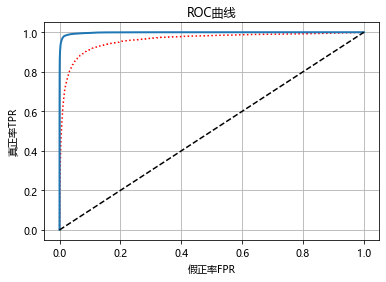

In [39]:
plt.plot(fpr, tpr, 'r:', label='SGD分类器')  # 绘制之前的SGD分类器作比较
plot_roc_curve(fpr_forest, tpr_forest, '随机森林')  # 这是之前自定义的函数

In [40]:
# 查看随机森林分类器的AUC
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

显然随机森林的AUC比SGD的AUC更大

In [41]:
# 查看随机森林的P和R
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores_forest)  
# 再次提醒，参数是真实标签和预测分数

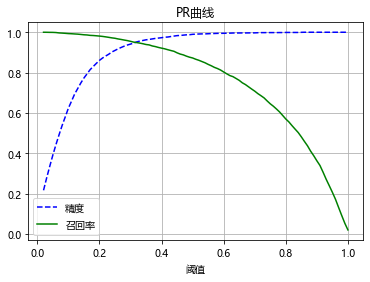

In [42]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

可见PR都可以维持在比较高的水平（0.9以上）

# 多类分类器

## 支持向量机SVM方法

OvR（One vs Rest）：策略是指一对剩余识别（是或否），例如对于10个数字，分类器0的任务是区分图像是否为0，分类器1的任务是区分图像是否为1，以此类推，特点是对于每一个分类器都要用全部训练集进行训练，大部分分类器适合这种方法

OvO（One vs One）：策略是指一对一识别（是0还是1），例如分类器0区分0和1，分类器1区分0和2，以此类推，共需要 N*(N-1)/2 个分类器，特点是对于每一个分类器，只需要用其需要的数据集进行训练（如分类器0只需要训练0和1的数据），在数据规模扩大时表现不佳的模型适合此策略，如SVM（支持向量机）

sklearn会根据需要自动选择策略

In [43]:
# 这里用支持向量机（其原理在第五章，此处不讨论）
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)  # 这里是多分类，不再用变量 y_train_5，可能会运行5分钟
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [44]:
some_digit_socres = svm_clf.decision_function([some_digit])  # 返回svm对于第一个数据对应各标签的预测分数

In [45]:
some_digit_socres  # 共10个分数，对应10个标签

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

> 其中第五个是最高的，刚好对应数字5（一般序号不会对应标签）

In [46]:
svm_clf.classes_  # .classes_ 储存类别，按值大小排序

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

以上sklearn自动用了OvO策略

### 指定SVC使用OvO或OvR

> 建议不要运行后面部分代码，将消耗大量时间（40分钟）

multiclass 模块中有 OneVsRestClassifier() 和 OneVsOneClassifier() ，可以传入其他分类器，从而指定其策略

In [48]:
# from sklearn.multiclass import OneVsRestClassifier
# ovr_clf = OneVsRestClassifier(SVC())  # 直接把SVC()传入即可实现SVC()的OvR策略
# ovr_clf.fit(X_train, y_train)  # 要训练比较长一段时间，这就是让SVC用OvR的代价...
# ovr_clf.predict([some_digit])  # 做预测

以上代码需要运行相当长时间，因此注释掉不做运行

In [68]:
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

预测的结果是3，笑掉大牙

In [50]:
sgd_clf.decision_function([some_digit])  # 康康分数

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [51]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')  # 可能运行几分钟

array([0.87365, 0.85835, 0.8689 ])

In [52]:
from sklearn.preprocessing import StandardScaler  # 做缩放效果会好一点
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))  # 标准化
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')  # 可能运行二十分钟以上

array([0.8983, 0.891 , 0.9018])

比之前强一点，可以拉到89%了

# 误差分析

## 误差展示

In [53]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)  # 可能要十五分钟以上

In [54]:
conf_mx = confusion_matrix(y_train, y_train_pred)

In [55]:
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

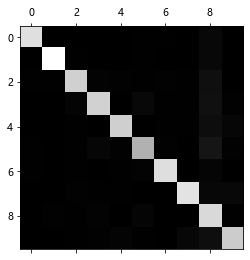

In [56]:
plt.matshow(conf_mx, cmap=plt.cm.gray)  # matshow()是矩阵绘图

可见效果还可以，大部分白色在对角线上，说明大部分被正确分类了

其中数字5的颜色稍暗一点，可能是因为5比较少，也可能是因为5被区分的效果不好

检查一下错误部分的情况，将错误值转化为错误率

In [57]:
row_sums = conf_mx.sum(axis=1, keepdims=True)  # 每一行加总
norm_conf_mx = conf_mx / row_sums  # 每个元素除以该行总数，得到错误率

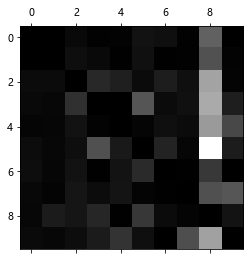

In [58]:
np.fill_diagonal(norm_conf_mx, 0)  # 用0填充主对角线，以便方便查看上下三角展示的错误情况
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)  # 展示矩阵
plt.show()

## 解决方案

可见，第八列数值较高，说明许多数字被错误预测为8，但第八行则比较暗，说明数字8大部分都被预测为了8，即对于8召回率高，精度低

因此，可以搜集更多的数字8的图片进行训练，或者写一些算法来改进，比如判断图像闭环的数量，数字8是两个闭环，数字6是一个闭环，数字5没有闭环，还可以用其他方法对图像进行预处理，使得特征更加突出

原书选取了一部分样本做了图片的混淆矩阵如下，代码不再加以展示!

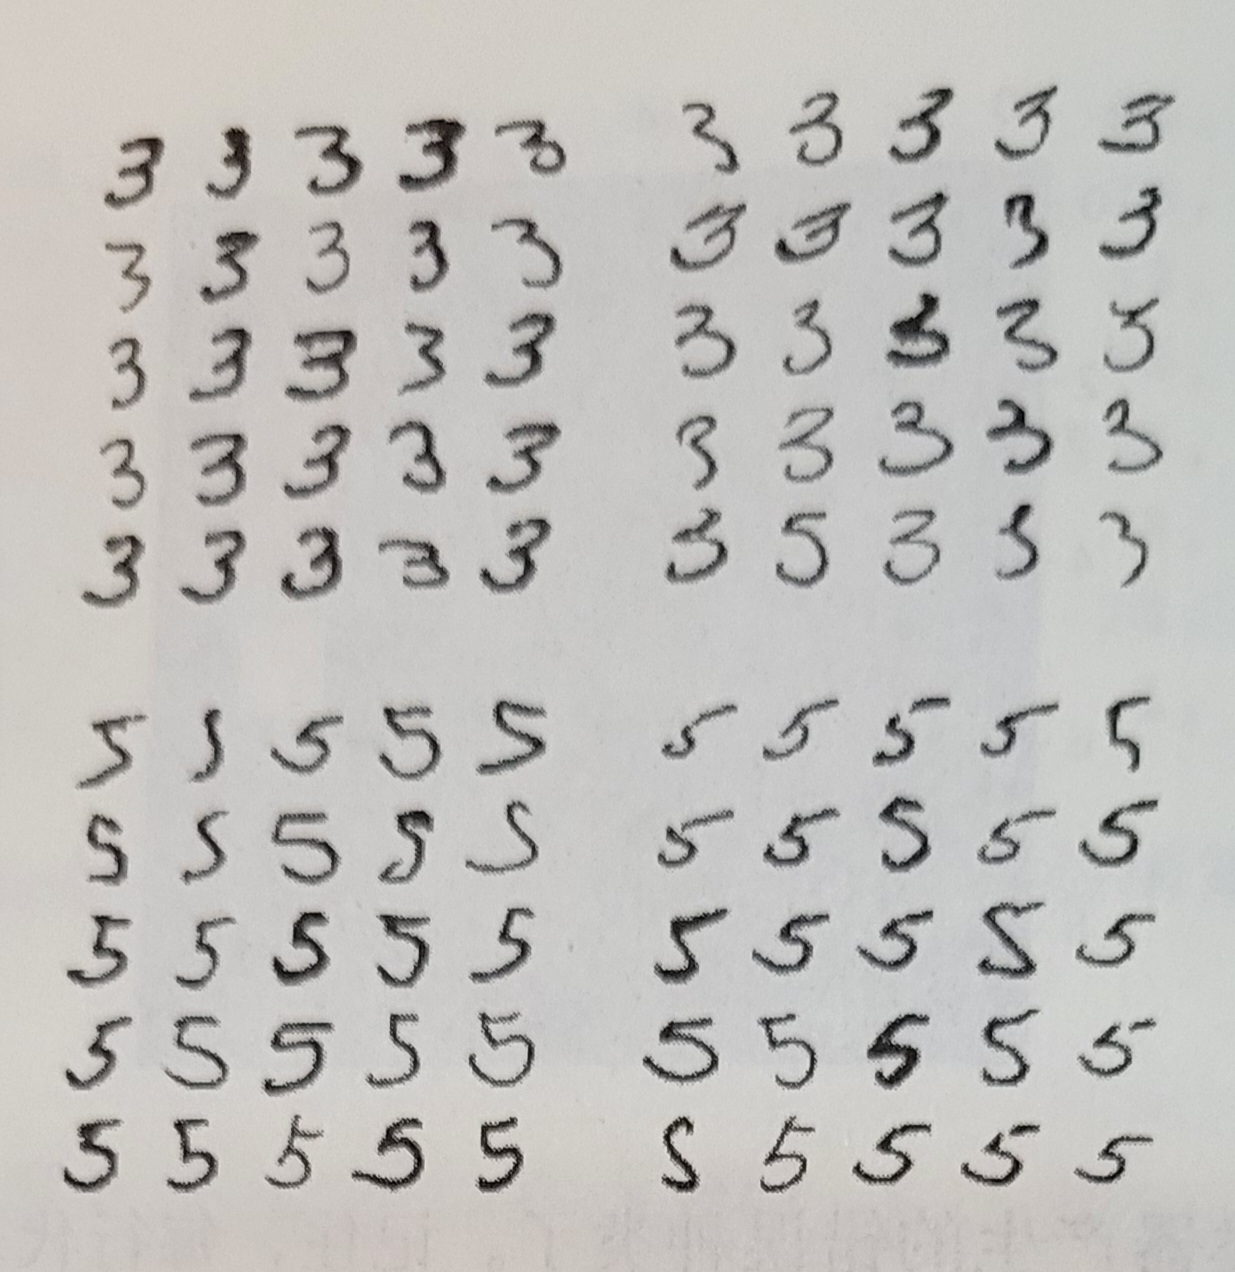

其中有一些字符连人类也很难分辨，而分类器主要就是给像素（向量）赋予权重，从而对像素进行打分，数字3和数字5的像素分布比较相似，所以容易混淆。

数字3和数字5之间主要区别在于连接顶线和下方弧线的中间那段小线条的位置，如果数字3的连接点往左移，分类器就可能将其分类为5。

总而言之，该分类器对于图像的位移和旋转很敏感，因此确保图像摆正或居于正中间位置，也对于提高分类效果有所帮助

# 多标签分类

有时候我们需要对识别到的内容进行多分类，比如既有1也有2，应该判断为1和2

## K近邻算法（本章不讨论原理）

In [59]:
from sklearn.neighbors import KNeighborsClassifier  # K近邻算法
y_train_large = (y_train >= 7)  # 大于7的标签
y_train_odd = (y_train % 2 == 1)  # 奇数标签
y_multilabel = np.c_[y_train_large, y_train_odd]  # 多标签

In [60]:
y_multilabel

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False,  True],
       [False, False],
       [ True, False]])

In [61]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [62]:
knn_clf.predict([some_digit])

array([[False,  True]])

预测结果是对的，数字5小于7（False），奇数（True）

下面进行评估，方法取决于项目是什么，这里展示$F_1$分数

In [63]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)  # 可能需要运行3分钟
f1_score(y_multilabel, y_train_knn_pred, average='macro')
# 这里average='macro'表示所有标签同等重要
# 实际情况下，若某一类标签比其他的都多，可以指定参数‘weighted’，按照标签数量匹配权重，其他指标看文档

0.976410265560605

可见F1分数比较高，一定程度上说明P和R都比较高

# 多输出分类

对于一个类别，可以有多个标签，比如多个可能的取值

这里我们构建一个系统去除图片中的噪声，实际上就是预测像素点的取值，这里很类似于回归

In [64]:
# 建立一个有噪声的图像
noise = np.random.randint(0, 100,(len(X_train), 784))  # 训练集噪声矩阵
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))  # 测试集噪声矩阵
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

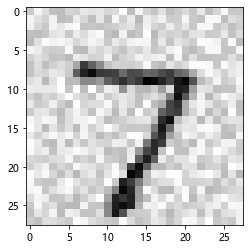

In [65]:
plt.imshow(X_test_mod[0].reshape(28, 28), cmap='binary')  # 在验证集取一个数查看，发现已经加入了噪点

In [66]:
knn_clf.fit(X_train_mod, y_train_mod)  # 在训练集训练像素

KNeighborsClassifier()

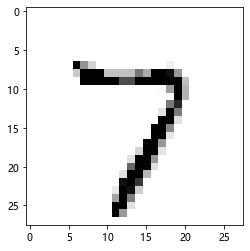

In [67]:
clean_digit = knn_clf.predict([X_test_mod[0]])  # 预测刚才查看的验证集的数字
plt.imshow(clean_digit.reshape(28, 28), cmap='binary')

这就是K近邻做像素预测从而去除噪点的方法